In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
id_test = test.id
train.sample(3)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
3525,3528,2012-09-07,32,18.0,4.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,6,6,0,1,42,5,4700000
26459,26462,2014-12-15,105,70.0,5.0,6.0,2.0,1977.0,4.0,8.0,...,331,129,25,116,211,2,92,180,13,29600000
26765,26768,2014-12-18,92,NaN,4.0,17.0,1.0,2014.0,2.0,1.0,...,371,141,26,150,249,2,105,203,13,14551800


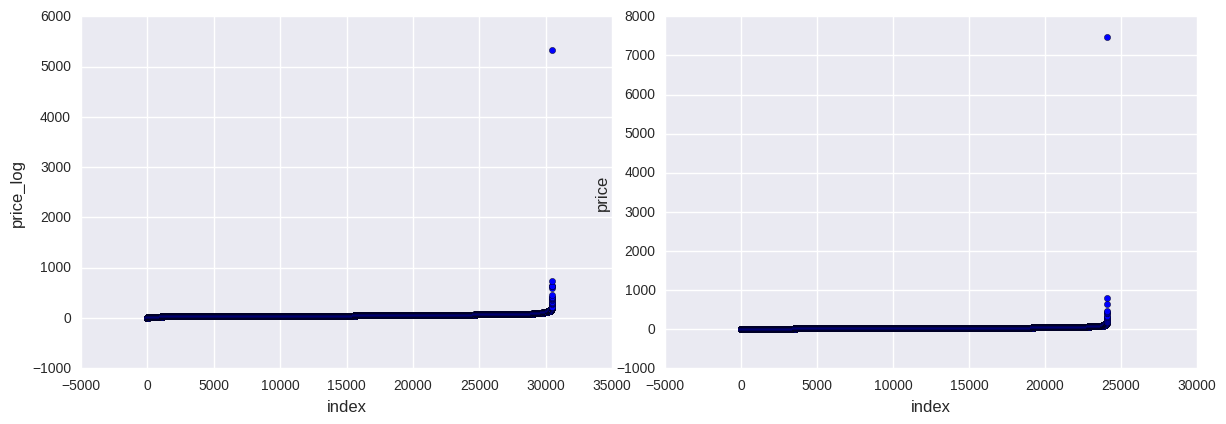

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(train.full_sq))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

axs[1].scatter(range(train.shape[0]), np.sort(train.life_sq))
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('price', fontsize=12)

In [45]:
ulimit = np.percentile(train.full_sq.values, 99.5)
index = train.full_sq.values < ulimit
print ulimit
print index.sum()
train = train[index]

155.0
30312


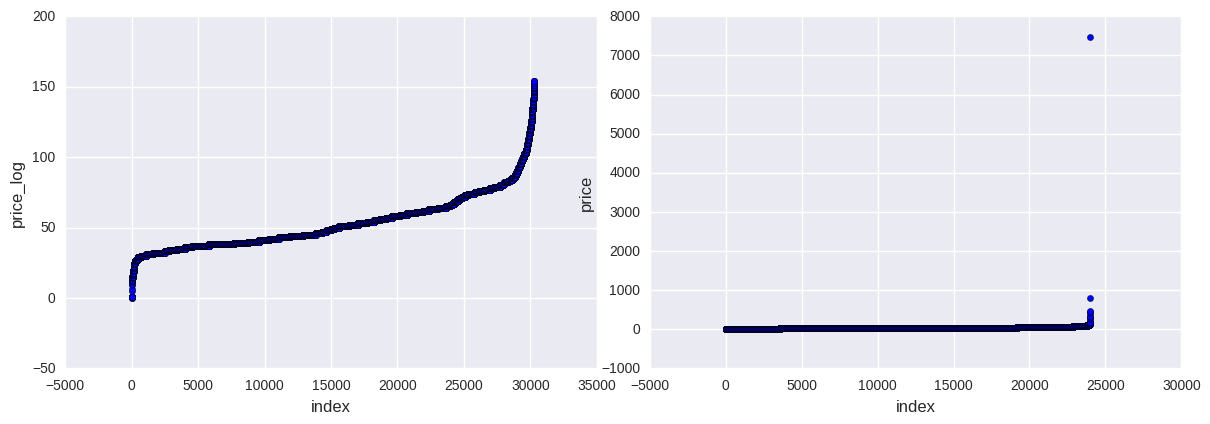

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(train.full_sq))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

axs[1].scatter(range(train.shape[0]), np.sort(train.life_sq))
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('price', fontsize=12)

In [47]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30312.000000,30312.000000,23982.000000,30147.000000,20824.000000,20824.000000,1.681000e+04,20824.000000,20824.000000,16859.000000,...,30312.000000,30312.000000,30312.000000,30312.000000,30312.000000,30312.000000,30312.000000,30312.000000,30312.000000,3.031200e+04
mean,15252.716746,53.276524,33.965933,7.659336,12.564541,1.822897,3.072226e+03,1.903861,6.377929,2.107717,...,31.836039,10.706915,1.755872,14.986639,30.132753,0.440947,8.595309,52.679533,5.984264,7.027358e+06
std,8791.908105,19.404748,51.751223,5.291081,6.733322,1.478639,1.546447e+05,0.840538,28.305439,0.879041,...,73.124961,28.240895,5.392048,28.996513,47.157478,0.608418,20.482149,46.190426,4.891881,4.378027e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7651.750000,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.739987e+06
50%,15254.500000,49.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,47.000000,5.000000,6.255627e+06
75%,22869.250000,63.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.000000,5.000000,0.000000,12.000000,28.000000,1.000000,7.000000,75.000000,10.000000,8.250000e+06
max,30473.000000,154.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


In [48]:
train["life_sq"].fillna(-1, inplace=True)
ulimit = np.percentile(train.life_sq.values, 99.5)
print ulimit
index = train.life_sq.values < ulimit
print ulimit
print index.sum()
train = train[index]

102.0
102.0
30148


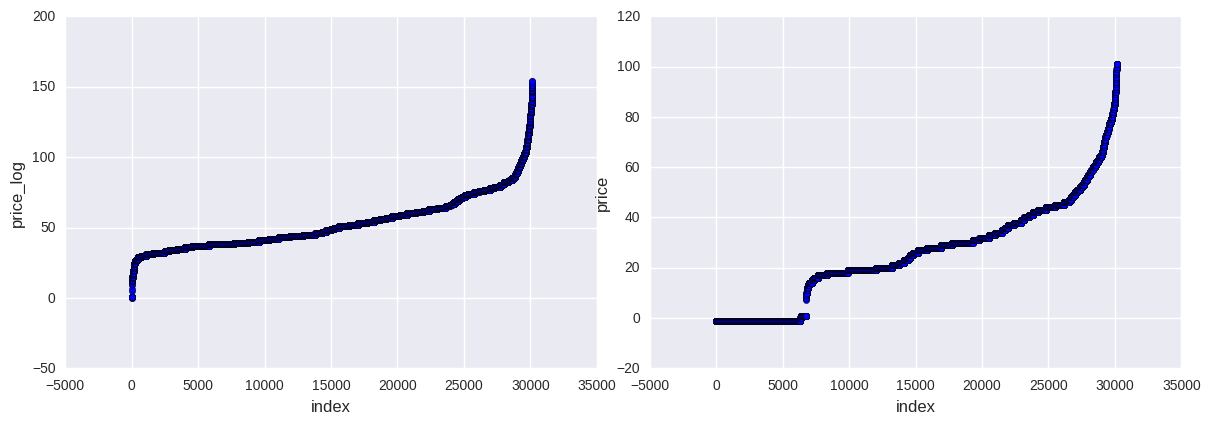

In [49]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(train.full_sq))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

axs[1].scatter(range(train.shape[0]), np.sort(train.life_sq))
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('price', fontsize=12)


In [50]:
print train.shape

(30148, 292)


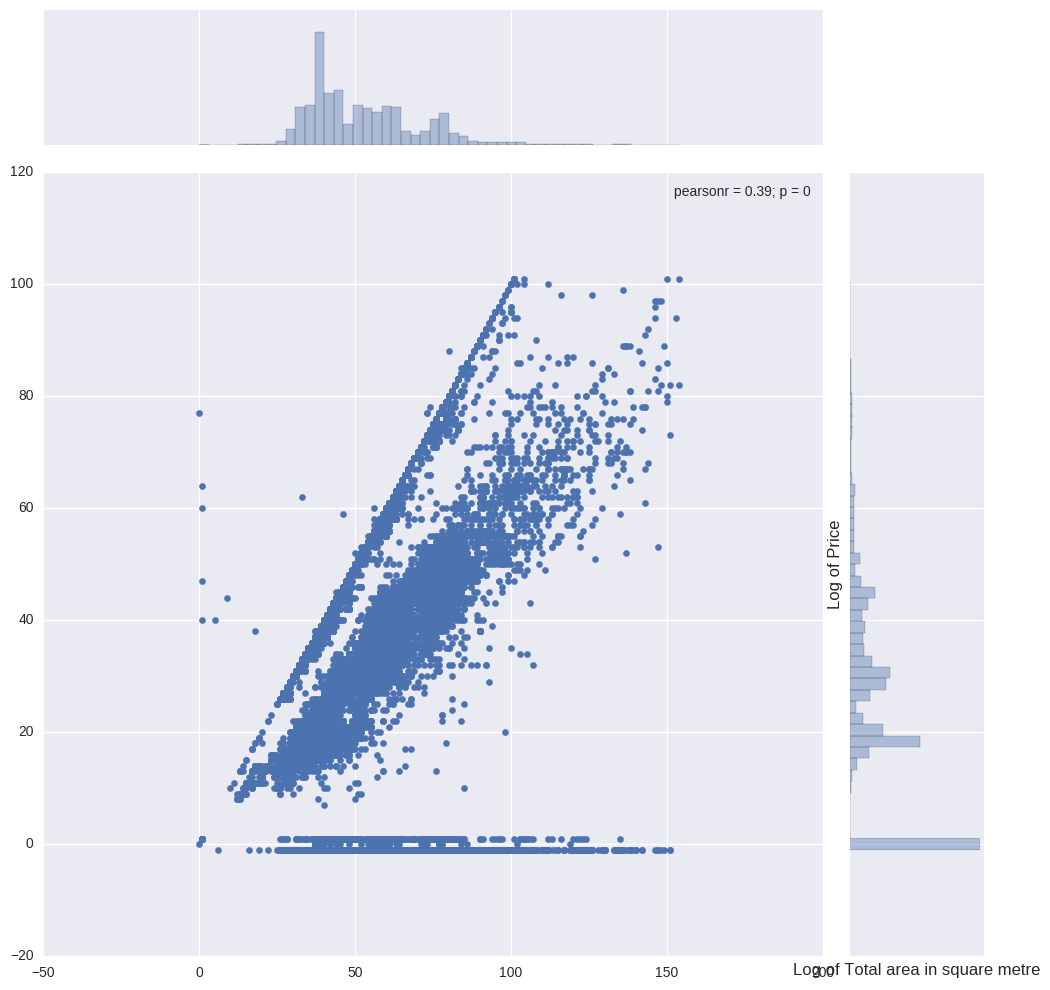

In [51]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train.full_sq.values, y=train.life_sq.values, size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

In [52]:
index = train.full_sq >= train.life_sq
print index.sum()
train = train[index]

30124


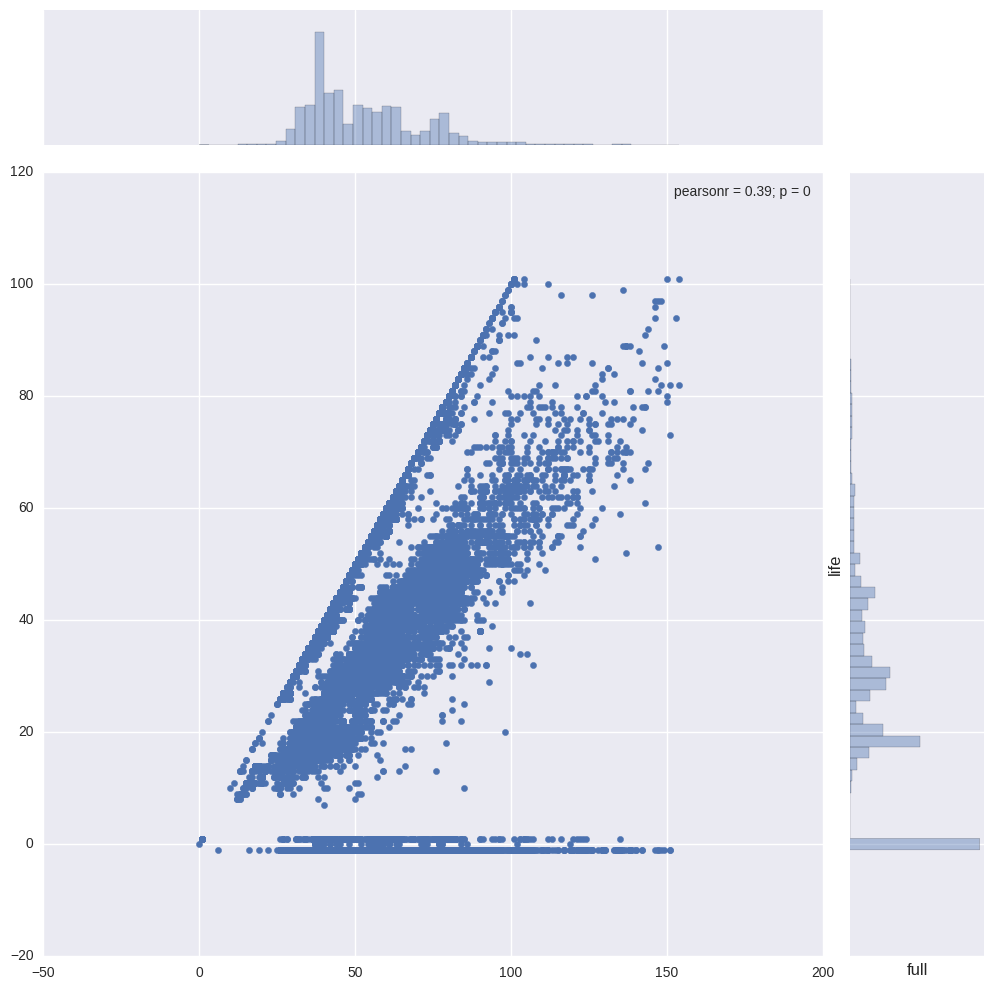

In [53]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train.full_sq.values, y=train.life_sq.values, size=10)
plt.ylabel('life', fontsize=12)
plt.xlabel('full', fontsize=12)
plt.show()

In [54]:
train['ratio'] = train['life_sq'] / train['full_sq']

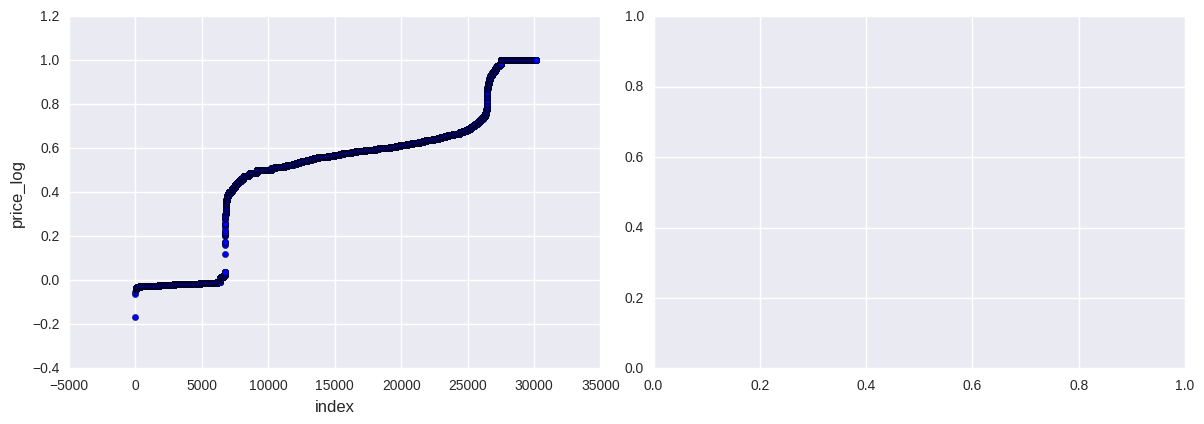

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(train.ratio))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

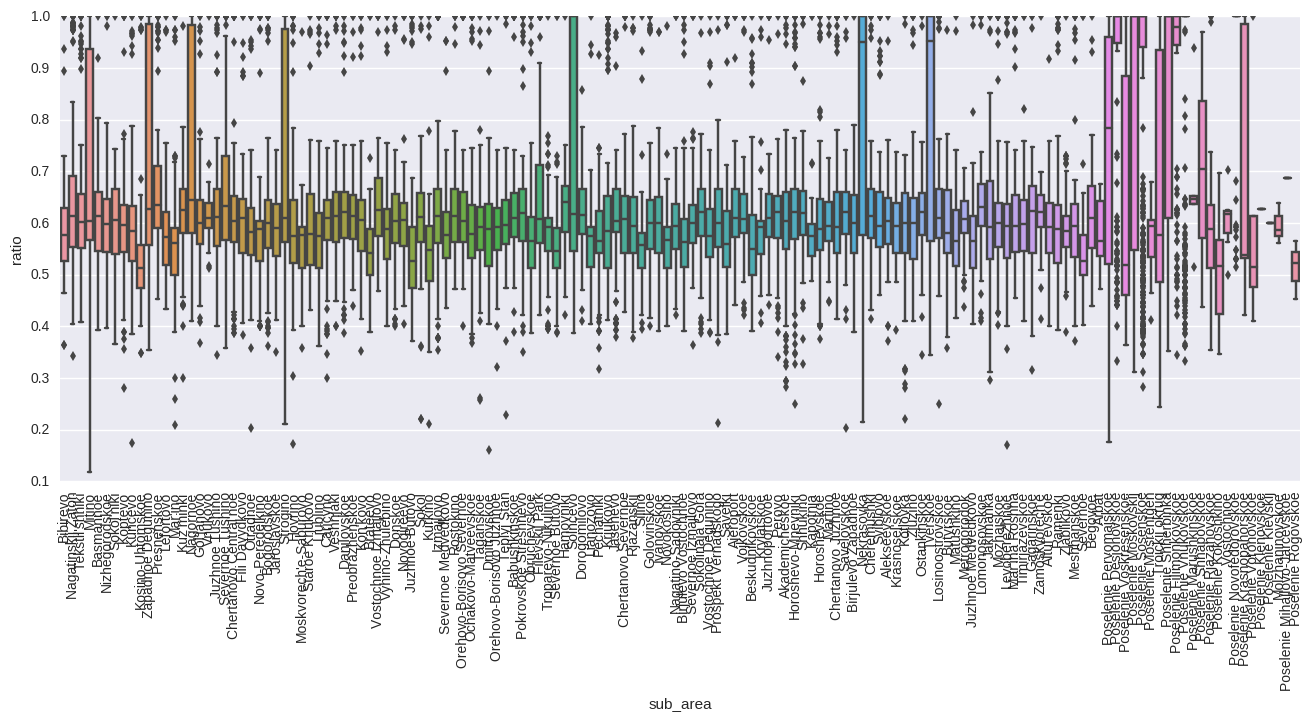

In [59]:
plt.figure(figsize=(16,6))
sns.boxplot(x = "sub_area", y = 'ratio', data = train[train['ratio'] > 0.1])
plt.xticks(rotation = 90)
plt.show()

In [61]:
ratio = train[train['ratio'] > 0.1].groupby('sub_area')['ratio'].aggregate(np.median).reset_index()

In [62]:
print ratio

                   sub_area     ratio
0                 Ajeroport  0.610434
1            Akademicheskoe  0.604651
2              Alekseevskoe  0.603774
3              Altuf'evskoe  0.591747
4                     Arbat  0.565217
5             Babushkinskoe  0.609756
6                 Basmannoe  0.613836
7                   Begovoe  0.609859
8           Beskudnikovskoe  0.550000
9                  Bibirevo  0.576923
10     Birjulevo Vostochnoe  0.562500
11       Birjulevo Zapadnoe  0.600000
12              Bogorodskoe  0.600000
13                 Brateevo  0.541457
14                Butyrskoe  0.580645
15                 Caricyno  0.610434
16              Cheremushki  0.612903
17   Chertanovo Central'noe  0.603774
18       Chertanovo Juzhnoe  0.592105
19      Chertanovo Severnoe  0.608108
20              Danilovskoe  0.620690
21              Dmitrovskoe  0.587596
22                  Donskoe  0.604518
23             Dorogomilovo  0.615275
24           Filevskij Park  0.608108
25          

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(ratio.shape[0]), np.sort(ratio.ratio))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

In [ ]:
index = train[train['ratio'] < 0.1].index
for ii in index:
    sub = train.iloc[ii]['sub_area']
    train.iloc[ii]['ratio'] = ratio[ratio['sub_area']==sub].ratio
#    print sub, ratio[ratio['sub_area']==sub].ratio.values



In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(train.ratio))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)
